# Análisis y Modelado del Conjunto de Datos del Titanic

En este notebook, realizaremos un análisis exploratorio de los datos (EDA) y construiremos un modelo de clasificación usando `StackingClassifier` con varios algoritmos como RandomForest, CatBoost, LightGBM y XGBoost. También incluiremos gráficos para visualizar las relaciones entre las características y la variable objetivo (`Survived`).

In [105]:
## 1. Cargar Bibliotecas y Datos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Cargar el conjunto de datos
train = pd.read_csv('D:\\Ale\\Competitions\\Titanic\\Data\\train.csv')

2. Limpieza de Datos
Rellenar valores nulos en las columnas categóricas y numéricas.

In [106]:
# Rellenar valores nulos en el conjunto de entrenamiento
for column in train.columns:
    if train[column].dtype == 'object':
        train[column].fillna(train[column].mode()[0], inplace=True)
    else:
        train[column].fillna(train[column].mean(), inplace=True)

C:\Users\Gubier\AppData\Local\Temp\ipykernel_1740\2785589293.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[column].fillna(train[column].mean(), inplace=True)
C:\Users\Gubier\AppData\Local\Temp\ipykernel_1740\2785589293.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


3. Ingeniería de Características
Crear la característica Familia Size

In [107]:
train['Familia Size'] = train['SibSp'] + train['Parch'] + 1

Extraer y simplificar los títulos de los nombres

In [108]:
import re
train['Title'] = train['Name'].apply(lambda x: re.findall(r', (.*?)\.', x)[0])

# Agrupar títulos raros
title_replacements = {
    'Mme': 'Mrs', 'Mlle': 'Miss', 'Ms': 'Miss', 'Countess': 'Rare', 
    'Lady': 'Rare', 'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 
    'Major': 'Rare', 'Capt': 'Rare', 'Don': 'Rare', 'Dona': 'Rare'
}
train['Title'] = train['Title'].replace(title_replacements)

Crear categorías de edad

In [109]:
def categorize_age(age):
    if age <= 5:
        return 'Child'
    elif age <= 12:
        return 'Young'
    elif age <= 18:
        return 'Teenager'
    elif age <= 60:
        return 'Adult'
    else:
        return 'Senior'

train['Age Category'] = train['Age'].apply(categorize_age)

Crear binning de Fare

In [110]:
max_fare = train['Fare'].max()
bins = [0, max_fare / 4, max_fare / 2, 3 * max_fare / 4, float('inf')]
labels = ['Barato', 'Semi Barato', 'Semi Caro', 'Caro']
train['Fare Category'] = pd.cut(train['Fare'], bins=bins, labels=labels, right=False)

4. Visualización de Datos
Distribución de Survived

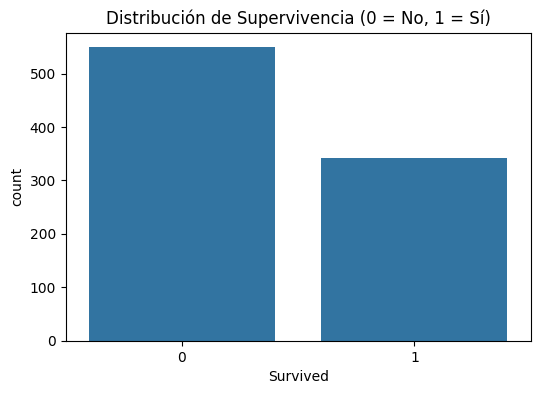

In [111]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Survived')
plt.title('Distribución de Supervivencia (0 = No, 1 = Sí)')
plt.show()

Relación entre Sex y Survived

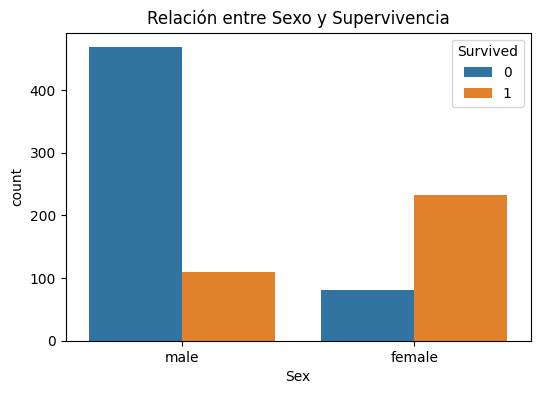

In [112]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Relación entre Sexo y Supervivencia')
plt.show()

Relación entre Pclass y Survived

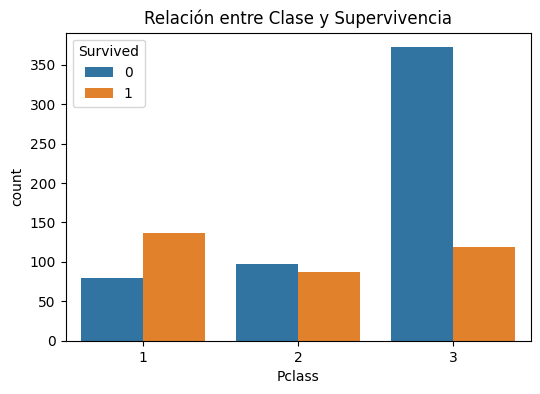

In [113]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Relación entre Clase y Supervivencia')
plt.show()

5. Preprocesamiento de Datos
Convertir variables categóricas a numéricas usando LabelEncoder

In [114]:
le = LabelEncoder()
categorical_cols = ['Sex', 'Embarked', 'Title', 'Age Category', 'Fare Category']

for col in categorical_cols:
    train[col] = le.fit_transform(train[col].astype(str))

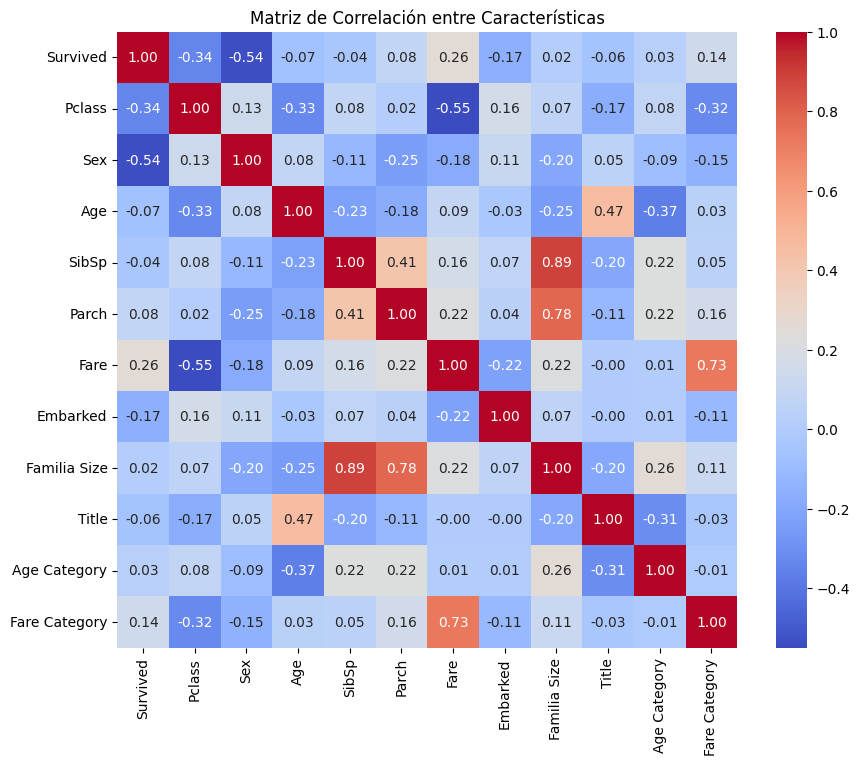

In [115]:
# 1. Eliminar la columna 'Name' antes de calcular la correlación
train_corr = train.drop(columns=['Name',"Ticket","Cabin","PassengerId"])

# 2. Generar la matriz de correlación y mostrarla
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Características')
plt.show()

6. División de Datos en Entrenamiento y Prueba

In [116]:
X = train[['Sex', 'Age', 'Familia Size', 'Fare', 'Embarked', 'Pclass', 'Title', 'Age Category', 'Fare Category']]
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

7. Construcción del Modelo de Stacking
Definir y entrenar el modelo de stacking con varios clasificadores

In [117]:
stacking_model = StackingClassifier(
    estimators=[
        ('Random Forest', RandomForestClassifier(random_state=42)),
        ('CatBoost', CatBoostClassifier(silent=True)),
        ('LightGBM', LGBMClassifier()),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ],
    final_estimator=RidgeClassifier(),
    cv=5
)

stacking_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

d:\Pyt\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

d:\Pyt\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Pyt\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Pyt\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Pyt\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:47] WARNING: C:\buildkite-agent

StackingClassifier(cv=5,
                   estimators=[('Random Forest',
                                RandomForestClassifier(random_state=42)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x000001D226DA7560>),
                               ('LightGBM', LGBMClassifier()),
                               ('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=RidgeClassifier())

8. Evaluación del Modelo
Predicción y cálculo de la precisión

In [118]:
y_pred_stacking = stacking_model.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f'Accuracy del Stacking Model: {accuracy_stacking:.2f}')

Accuracy del Stacking Model: 0.82


Matriz de confusión

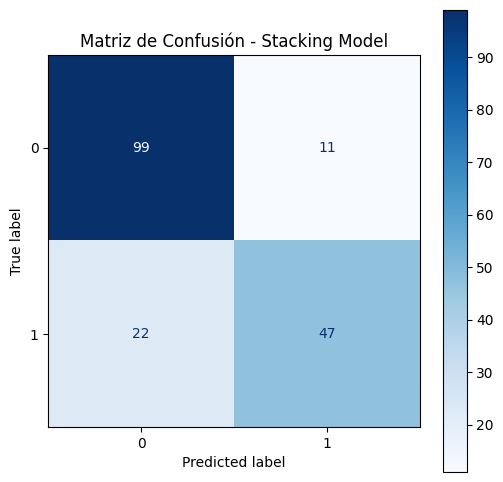

In [119]:
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(6, 6))
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_stacking, display_labels=[0, 1])
disp_stacking.plot(cmap='Blues', ax=plt.gca())
plt.title('Matriz de Confusión - Stacking Model')
plt.show()

9. Predicciones para el Conjunto de Test

In [120]:
# Cargar el conjunto de prueba
test_data = pd.read_csv('D:\\Ale\\Competitions\\Titanic\\Data\\test.csv')

# 1. Rellenar valores nulos en el conjunto de prueba
for column in test_data.columns:
    if test_data[column].dtype == 'object':
        test_data[column].fillna(test_data[column].mode()[0], inplace=True)
    else:
        test_data[column].fillna(test_data[column].mean(), inplace=True)

# 2. Crear la característica 'Familia Size'
test_data['Familia Size'] = test_data['SibSp'] + test_data['Parch'] + 1

# 3. Extraer el 'Title' de la columna 'Name'
test_data['Title'] = test_data['Name'].apply(lambda x: re.findall(r', (.*?)\.', x)[0])

# Agrupar títulos poco comunes
test_data['Title'] = test_data['Title'].replace(title_replacements)

# 4. Crear categorías de edad
test_data['Age Category'] = test_data['Age'].apply(categorize_age)

# 5. Binning de 'Fare'
max_fare = test_data['Fare'].max()  # Encontrar el máximo valor de Fare
bins = [0, max_fare / 4, max_fare / 2, 3 * max_fare / 4, max_fare]  # Dividir en 4 bins
labels = ['Low', 'Medium', 'High', 'Very High']  # Etiquetas para los bins
test_data['Fare Category'] = pd.cut(test_data['Fare'], bins=bins, labels=labels, right=False)

# 6. Normalizar los valores de las columnas categóricas antes de aplicar Label Encoding
test_data['Sex'] = test_data['Sex'].str.lower()
test_data['Embarked'] = test_data['Embarked'].str.lower()
test_data['Title'] = test_data['Title'].str.lower()
test_data['Age Category'] = test_data['Age Category'].str.lower()
test_data['Fare Category'] = test_data['Fare Category'].str.lower()

# 7. Convertir variables categóricas a numéricas usando Label Encoding
# Transformar el conjunto de prueba
for col in categorical_cols:
    # Manejar el caso de categorías no vistas
    if test_data[col].isin(le.classes_).all():
        test_data[col] = le.transform(test_data[col].astype(str))
    else:
        # Si hay categorías no vistas, codificar solo las que sí están
        test_data[col] = le.fit_transform(test_data[col].astype(str))

# 8. Preparar los datos del conjunto de prueba para el modelo
X_test_final = test_data[['Sex', 'Age', 'Familia Size', 'Fare', 'Embarked', 'Pclass', 'Title', 'Age Category', 'Fare Category']]

# 9. Hacer predicciones sobre el conjunto de test
y_test_pred = stacking_model.predict(X_test_final)

# 10. Crear el archivo de submission
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': y_test_pred})
submission.to_csv('D:\\Ale\\Competitions\\Titanic\\Data\\submission.csv', index=False)

C:\Users\Gubier\AppData\Local\Temp\ipykernel_1740\1703435482.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data[column].fillna(test_data[column].mean(), inplace=True)
C:\Users\Gubier\AppData\Local\Temp\ipykernel_1740\1703435482.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 